<a href="https://colab.research.google.com/github/romina-a/JAX-GAN/blob/main/DC-GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN using STAX

#Prerequisits



#defining data loader

In [10]:
import numpy as np
import jax.numpy as jnp

# ~~~~~~~~~~~~~~~~~~~~~~~~~ UTILS FOR LOADING DATA WITH PYTORCH ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
from torch.utils import data
from torchvision.datasets import MNIST, CIFAR10


def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)


class NumpyLoader(data.DataLoader):
    def __init__(self, dataset, batch_size=1,
                 shuffle=False, sampler=None,
                 batch_sampler=None, num_workers=0,
                 pin_memory=False, drop_last=False,
                 timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
                                             batch_size=batch_size,
                                             shuffle=shuffle,
                                             sampler=sampler,
                                             batch_sampler=batch_sampler,
                                             num_workers=num_workers,
                                             collate_fn=numpy_collate,
                                             pin_memory=pin_memory,
                                             drop_last=drop_last,
                                             timeout=timeout,
                                             worker_init_fn=worker_init_fn)


def flatten_and_cast(pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))


def cast(pic):
    pic = (np.array(pic, dtype=jnp.float32)-127.5)/127.5
    if len(pic.shape) == 2:
        pic = pic[..., np.newaxis]
    return pic


def mnist_dataset(batch_size, digit=None, flatten=False):
    data_adr = ""
    if flatten:
        mnist_dataset = MNIST('./tmp/mnist/', download=True, transform=flatten_and_cast)
    else:
        mnist_dataset = MNIST('./tmp/mnist/', download=True, transform=cast)
    if digit is not None:
        idx = mnist_dataset.targets == digit
        mnist_dataset.data = mnist_dataset.data[idx]
        mnist_dataset.targets = mnist_dataset.targets[idx]
    # load training with the generator (makes batch easier I think)
    training_generator = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)
    return training_generator


def cifar10_dataset(batch_size, digit=None):
    data_adr = ""
    cifar10_dataset = CIFAR10('./tmp/cifar10/', download=True, transform=cast)
    if digit is not None:
        idx = np.array(cifar10_dataset.targets) == digit
        cifar10_dataset.data = cifar10_dataset.data[idx]
        cifar10_dataset.targets = np.array(cifar10_dataset.targets)[idx]
    # load training with the generator (makes batch easier I think)
    training_generator = NumpyLoader(cifar10_dataset, batch_size=batch_size, num_workers=0)
    return training_generator


# Defining additional Stax layer and loss function

In [11]:
from jax.nn.initializers import normal
from jax.nn import leaky_relu, sigmoid
from jax.experimental import stax
from jax.experimental.stax import (BatchNorm, Conv, ConvTranspose, Dense,
                                   Tanh, Relu, Flatten, Sigmoid)
from jax.experimental.optimizers import pack_optimizer_state, unpack_optimizer_state
import jax.numpy as jnp
import jax.random as random

from jax.lax import sort

from jax import value_and_grad, jit
from functools import partial
import pickle
import os

finfo = jnp.finfo(jnp.float32)
EPS = finfo.eps
EPSNEG = finfo.epsneg

# ~~~~~~~~~~~~ losses ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def BCE_from_logits(logits, targets):
    p = sigmoid(logits)
    loss_array = -jnp.log(jnp.where(p == 0, EPS, p)) * targets\
                 - jnp.log(1 - jnp.where(p == 1, 1-EPSNEG, p)) * (1 - targets)
    return jnp.mean(loss_array)

# ---------------------------- layers with stax convention --------------------------
def Reshape(output_shape):
    def init_fun(rng, input_shape):
        size_in = 1
        for a in input_shape[1:]: size_in = size_in * a
        size_out = 1
        for a in output_shape: size_out = size_out * a
        assert size_out == size_in, "input and output sizes must match"
        return (input_shape[0], *output_shape[:]), ()

    def apply_fun(params, inputs, **kwargs):
        return jnp.reshape(inputs, (inputs.shape[0], *output_shape))

    return init_fun, apply_fun

def LeakyRelu(negative_slope):
    return stax.elementwise(leaky_relu, negative_slope=negative_slope)

defining generator and discriminator models

In [12]:
# -----------------------------------   Network Models   ------------------------------------
def conv_generator_mnist():
    model = stax.serial(
        Dense(1024 * 7 * 7),
        Reshape((7, 7, 1024)),
        ConvTranspose(out_chan=512, filter_shape=(5, 5), strides=(1, 1),
                      padding='SAME', W_init=normal(2e-2), b_init=normal(2e-2)),
        BatchNorm(), Relu,
        ConvTranspose(out_chan=256, filter_shape=(5, 5), strides=(2, 2),
                      padding='SAME', W_init=normal(2e-2), b_init=normal(2e-2)),
        BatchNorm(), Relu,
        ConvTranspose(out_chan=128, filter_shape=(5, 5), strides=(2, 2),
                      padding='SAME', W_init=normal(2e-2), b_init=normal(2e-2)),
        BatchNorm(), Relu,
        ConvTranspose(out_chan=1, filter_shape=(5, 5), strides=(1, 1),
                      padding='SAME', W_init=normal(2e-2), b_init=normal(2e-2)),
        Tanh,
    )
    return model


def conv_generator_cifar10():
    model = stax.serial(
        Dense(1024 * 2 * 2),
        Reshape((2, 2, 1024)),
        ConvTranspose(out_chan=512, filter_shape=(5, 5), strides=(2, 2),
                      padding='SAME', W_init=normal(2e-2), b_init=normal(2e-2)),
        BatchNorm(), Relu,
        ConvTranspose(out_chan=256, filter_shape=(5, 5), strides=(2, 2),
                      padding='SAME', W_init=normal(2e-2), b_init=normal(2e-2)),
        BatchNorm(), Relu,
        ConvTranspose(out_chan=128, filter_shape=(5, 5), strides=(2, 2),
                      padding='SAME', W_init=normal(2e-2), b_init=normal(2e-2)),
        BatchNorm(), Relu,
        ConvTranspose(out_chan=3, filter_shape=(5, 5), strides=(2, 2),
                      padding='SAME', W_init=normal(2e-2), b_init=normal(2e-2)),
        Tanh,
    )
    return model


def conv_discriminator():
    model = stax.serial(
        Conv(out_chan=64, filter_shape=(5, 5), strides=(2, 2),
             padding='SAME', W_init=normal(2e-2), b_init=normal(1e-6)),
        LeakyRelu(negative_slope=0.2),
        Conv(out_chan=128, filter_shape=(5, 5), strides=(2, 2),
             padding='SAME', W_init=normal(2e-2), b_init=normal(1e-6)),
        BatchNorm(), LeakyRelu(negative_slope=0.2),
        Conv(out_chan=256, filter_shape=(5, 5), strides=(2, 2),
             padding='SAME', W_init=normal(2e-2), b_init=normal(1e-6)),
        BatchNorm(), LeakyRelu(negative_slope=0.2),
        Conv(out_chan=512, filter_shape=(5, 5), strides=(2, 2),
             padding='SAME', W_init=normal(2e-2), b_init=normal(1e-6)),
        BatchNorm(), LeakyRelu(negative_slope=0.2), Flatten,
        Dense(1),
        # Sigmoid
    )
    return model

# GAN

Defining GAN Class. The static methods are to save and load GANs

In [13]:
# ----------------------------------- GAN --------------------------------------------
class GAN:
    r"""
    GAN implementation using jax.experimental
    generator and discriminator are jax.experimental.stax models: (init_func, apply_func) pairs
    optimizers are jax.experimental.optimizers optimizers: (init, update, get_params) triplets
    """

    @staticmethod
    def save_gan_to_file(gan, d_state, g_state, save_adr):
        params = {'d_creator': gan.d_creator,
                  'g_creator': gan.g_creator,
                  'd_opt_creator': gan.d_opt_creator,
                  'g_opt_creator': gan.g_opt_creator,
                  'loss_function': gan.loss_function,
                  'batch_size': gan.batch_size,
                  'd_input_shape': gan.d_input_shape,
                  'g_input_shape': gan.g_input_shape,
                  'd_output_shape': gan.d_output_shape,
                  'g_output_shape': gan.g_output_shape,
                  'g_state': unpack_optimizer_state(g_state),
                  'd_state': unpack_optimizer_state(d_state)
                  }
        with open(save_adr, 'wb') as f:
            pickle.dump(params, f)

    @staticmethod
    def load_gan_from_file(load_adr):
        with open(load_adr, 'rb') as f:
            params = pickle.load(f)
        if params['d_state'] is not None:
            params['d_state'] = pack_optimizer_state(params['d_state'])
        if params['g_state'] is not None:
            params['g_state'] = pack_optimizer_state(params['g_state'])
        gan = GAN(params['d_creator'], params['g_creator'], params['d_opt_creator'], params['g_opt_creator'],
                  params['loss_function'])
        gan.d_output_shape = params['d_output_shape']
        gan.g_output_shape = params['g_output_shape']
        gan.d_input_shape = params['d_input_shape']
        gan.g_input_shape = params['g_input_shape']
        gan.batch_size = params['batch_size']
        return gan, params['d_state'], params['g_state']

    def __init__(self, d_creator, g_creator, d_opt_creator, g_opt_creator, loss_function):
        """

        :param d_creator: (callable) with no input returns discriminator stax model: (init_func, apply_func)
        :param g_creator: (callable) with no input returns generator stax model: (init_func, apply_func)
        :param d_opt_creator: (callable) with no input returns discriminator optimizer: (init, update, get_params)
        :param g_opt_creator: (callable) with no input returns generator optimizer: (init, update, get_params)
        :param loss_function: (function) to calculate loss from discriminator outputs:
                      (discriminator-outputs, real-labels)-> loss
        """
        d_init, d_apply = d_creator()
        g_init, g_apply = g_creator()
        (d_opt_init, d_opt_update, d_opt_get_params) = d_opt_creator()
        (g_opt_init, g_opt_update, g_opt_get_params) = g_opt_creator()

        # self.creators = {'d_creator': d_creator,
        #                  'g_creator': g_creator,
        #                  'd_opt_creator': d_opt_creator,
        #                  'g_opt_creator': g_opt_creator
        #                  }
        self.d_creator = d_creator
        self.g_creator = g_creator
        self.d_opt_creator = d_opt_creator
        self.g_opt_creator = g_opt_creator
        self.d = {'init': d_init, 'apply': d_apply}
        self.g = {'init': g_init, 'apply': g_apply}
        self.d_opt = {'init': d_opt_init, 'update': d_opt_update, 'get_params': d_opt_get_params}
        self.g_opt = {'init': g_opt_init, 'update': g_opt_update, 'get_params': g_opt_get_params}
        self.loss_function = loss_function
        self.d_output_shape = None
        self.g_output_shape = None
        self.d_input_shape = None
        self.g_input_shape = None
        self.batch_size = None

    def init(self, prng_d, prng_g, d_input_shape, g_input_shape, batch_size):
        """

        :param prng_d: (jax.PRNGKey) for discriminator initialization
        :param prng_g: (jax.PRNGKey) for generator initialization
        :param d_input_shape: (tuple) shape of the discriminator input excluding batch size
        :param g_input_shape: (tuple) shape of the generator input excluding batch size
        :param batch_size: (int) used for initialization and training
        :return: discriminator and generator states (needed for train_step and generate_samples)
        """
        self.g_input_shape = g_input_shape
        self.d_input_shape = d_input_shape
        self.d_output_shape, d_params = self.d['init'](prng_d, (batch_size, *d_input_shape))
        self.g_output_shape, g_params = self.g['init'](prng_g, (batch_size, *g_input_shape))
        self.batch_size = batch_size
        d_state = self.d_opt['init'](d_params)
        g_state = self.g_opt['init'](g_params)
        return d_state, g_state

    @partial(jit, static_argnums=(0,))
    def _d_loss(self, d_params, g_params, z, real_samples):
        fake_ims = self.g['apply'](g_params, z)

        fake_predictions = self.d['apply'](d_params, fake_ims)
        real_predictions = self.d['apply'](d_params, real_samples)
        fake_loss = self.loss_function(fake_predictions, jnp.zeros_like(fake_predictions))
        real_loss = self.loss_function(real_predictions, jnp.ones_like(real_predictions))

        return fake_loss + real_loss

    @partial(jit, static_argnums=(0, 4))
    def _g_loss(self, g_params, d_params, z, k):
        fake_ims = self.g['apply'](g_params, z)

        fake_predictions = self.d['apply'](d_params, fake_ims)
        fake_predictions = sort(fake_predictions, 0)
        fake_predictions = jnp.flip(fake_predictions, 0)
        fake_predictions = fake_predictions[:k]

        loss = self.loss_function(fake_predictions, jnp.ones_like(fake_predictions))

        return loss

    @partial(jit, static_argnums=(0, 6))
    def train_step(self, i, prng_key, d_state, g_state, real_samples, k):
        """
        !: call init function before train_step

        :param i: (int) step number
        :param prng_key: (jax.random.PRNGKey) used to create random samples from the generator
        :param d_state: previous discriminator state
        :param g_state: previous generator state
        :param real_samples: (np/jnp array) samples form the training set
        :param k: (int) to choose top k for training generator, if None all elements are chosen
        :return: updated discriminator and generator states and discriminator and generator loss values
        """
        k = k or self.batch_size
        prng1, prng2 = random.split(prng_key, 2)
        d_params = self.d_opt['get_params'](d_state)
        g_params = self.g_opt['get_params'](g_state)

        z = random.normal(prng1, (self.batch_size, *self.g_input_shape))
        d_loss_value, d_grads = value_and_grad(self._d_loss)(d_params, g_params, z, real_samples)
        d_state = self.d_opt['update'](i, d_grads, d_state)

        z = random.normal(prng2, (self.batch_size, *self.g_input_shape))
        g_loss_value, g_grads = value_and_grad(self._g_loss)(g_params, d_params, z, k)
        g_state = self.g_opt['update'](i, g_grads, g_state)

        return d_state, g_state, d_loss_value, g_loss_value

    @partial(jit, static_argnums=(0,))
    def generate_samples(self, z, g_state):
        """

        :param z: (np/jnp array) shape: (n, generator_input_dims)
        :param g_state: generator state
        :return: (jnp array) shape: (n, generator_output_dims) n generated samples
        """
        fakes = self.g['apply'](self.g_opt['get_params'](g_state), z)
        return fakes

    @partial(jit, static_argnums=(0,))
    def rate_samples(self, samples, d_state):
        """

        :return: (jnp array) shape: (n, 1) discriminator ratings for the samples
        """
        rates = self.d['apply'](self.d_opt['get_params'](d_state), samples)
        return rates


# defining training procedure

setting Hyperparameters

In [27]:
import jax
import jax.numpy as jnp
from jax.experimental.optimizers import adam

import matplotlib.pyplot as plt
import argparse
import time
from functools import partial


dataset = 'cifar10' 
#can change to 'mnist'

digit = None 
#can change to any number between 0 to 9 [for generating a specific class]

batch_size = 128
num_iter = 20000

batch_size_min = 64 #nu
decay_rate = 0.99 #gamma

lr = 0.0002
momentum = 0.5
momentum2 = 0.99

loss_function = BCE_from_logits

top_k = 1 #if 0 top-k method will not be used

dataset_loaders = {'mnist': mnist_dataset, 'cifar10': cifar10_dataset}
generators = {'mnist': conv_generator_mnist, 'cifar10': conv_generator_cifar10}

g_input_shape=(100,)
d_input_shapes={'mnist': (28,28,1), 'cifar10': (32,32,3)}

helper method to initialize gan. prng is a jax.random.PRNGKey used for pseudo-random layer initialization of discriminator and generator

In [28]:
def create_and_initialize_gan(prng):
    d_creator = conv_discriminator
    g_creator = generators[dataset]
    d_opt_creator = partial(adam, lr, momentum, momentum2)
    g_opt_creator = partial(adam, lr, momentum, momentum2)

    gan = GAN(d_creator, g_creator, d_opt_creator, g_opt_creator, 
              loss_function)

    prng1, prng2 = jax.random.split(prng, 2)
    d_state, g_state = gan.init(prng1, prng2, d_input_shapes[dataset], 
                                g_input_shape, batch_size)
    return gan, d_state, g_state

helper method to show samples

In [29]:
def plot_samples(ims, grid_dim):
    dim1 = grid_dim
    dim2 = len(ims)//dim1

    for i in range(len(ims)):
        im = ims[i]
        if im.shape[2] == 1:
            im = im.reshape(im.shape[:2])
        plt.subplot(dim1, dim2, i + 1)
        plt.imshow((im + 1.0) / 2.0)
        plt.axis('off')
    plt.show()


finally, the training method. Uncommnent the clear_output in order to clear the output before showing the results

In [32]:
from IPython.display import clear_output

def train():

    dataset_loader = dataset_loaders[dataset]
    real_data = dataset_loader(batch_size, digit=digit)
    

    prng = jax.random.PRNGKey(0)
    prng_to_use, prng = jax.random.split(prng, 2)
    gan, d_state, g_state = create_and_initialize_gan(prng_to_use)

    d_losses = []
    g_losses = []

    start_time = time.time()
    i = 0

    prng_images, prng = jax.random.split(prng, 2)
    z = jax.random.normal(prng_images, (9, 100))

    k = batch_size
    while i < num_iter:
        epoch_start_time = time.time()
        for real_ims, _ in real_data:
            if i >= num_iter:
                break

            prng, prng_to_use = jax.random.split(prng, 2)
            d_state, g_state, d_loss_value, g_loss_value = gan.train_step(i, 
                                   prng_to_use, d_state, g_state, real_ims, k)
            d_losses.append(d_loss_value)
            g_losses.append(g_loss_value)
            i = i + 1
        # clear_output()
        print(f'iter{i}/{num_iter}')
        print(f'epoch finished in {time.time() - epoch_start_time}second')
        plot_samples(gan.generate_samples(z, g_state), 3)
        if top_k == 1:
            k = int(k * decay_rate)
            k = max(batch_size_min, k)
            print(f"iter:{i}/{num_iter}, updated k: {k}")
    print(f'finished, took{time.time() - start_time}')

    return d_losses, g_losses, d_state, g_state, gan

# set up training

request to use TPU

In [ ]:
import os
import requests

if 'TPU_DRIVER_MODE' not in globals():
  url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
  resp = requests.post(url)
  TPU_DRIVER_MODE = 1

from jax.config import config
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
print(config.FLAGS.jax_backend_target)

# Train

epoch finished in 6.503149747848511


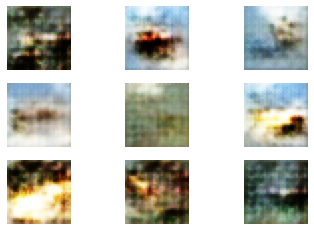

iter:2000/2000, updated k: 116
finished, took155.05937385559082


In [24]:
d_losses, g_losses, d_state, g_state, gan = train()

# Plot loss history

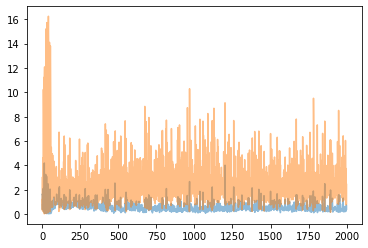

In [25]:
import matplotlib.pyplot as plt
plt.plot(d_losses, label="d_loss", alpha=0.5)
plt.plot(g_losses, label="d_loss", alpha=0.5)
plt.show()

# Save Gan

In [26]:
path = "./gan.pkl"
GAN.save_gan_to_file(gan, d_state, g_state, path)


# END